<a href="https://colab.research.google.com/github/felixn95/oil-palm-detection/blob/main/model_training/squeezenet_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Squeezenet** - Training & Tracking Models using NeptuneAI


In this notebook, the training is applied on the pretrained model squeezenet (https://pytorch.org/hub/pytorch_vision_squeezenet/) using the FastAI learner.
During the training, different versions of the model are applied. For later comparison with different models, all runs are tracked with their metrics in a centralized project in neptuneAI, where all teammembers collaborate togehter.

In [1]:
!pip install torch torchvision

In [2]:
!pip install fastai neptune neptune-fastai --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.3 MB/s eta 0:00:00


In [3]:
# load data set & unzip

!wget https://github.com/felixn95/tds_project/raw/main/wisdatathon2019.zip
!unzip wisdatathon2019.zip
!unzip wisdatathon2019/train_images.zip
!unzip wisdatathon2019/leaderboard_test_data.zip

train_images = '/content/train_images'
test_images =  '/content/leaderboard_test_data'
train_labels = '/content/wisdatathon2019/traininglabels.csv'
test_labels = '/content/wisdatathon2019/testlabels.csv'

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: leaderboard_test_data/img_04013.jpg  
  inflating: leaderboard_test_data/img_04014.jpg  
  inflating: leaderboard_test_data/img_04015.jpg  
  inflating: leaderboard_test_data/img_04016.jpg  
  inflating: leaderboard_test_data/img_04017.jpg  
  inflating: leaderboard_test_data/img_04018.jpg  
  inflating: leaderboard_test_data/img_04019.jpg  
  inflating: leaderboard_test_data/img_04020.jpg  
  inflating: leaderboard_test_data/img_04021.jpg  
  inflating: leaderboard_test_data/img_04022.jpg  
  inflating: leaderboard_test_data/img_04023.jpg  
  inflating: leaderboard_test_data/img_04024.jpg  
  inflating: leaderboard_test_data/img_04025.jpg  
  inflating: leaderboard_test_data/img_04026.jpg  
  inflating: leaderboard_test_data/img_04027.jpg  
  inflating: leaderboard_test_data/img_04028.jpg  
  inflating: leaderboard_test_data/img_04029.jpg  
  inflating: leaderboard_test_data/img_04030.jpg  
  inflating: le

The labeled images in the labels csv's do not fit to the image ids, because we need to remove the year at the end of the string in each row.

In [4]:
import pandas as pd
import os


def adjust_image_ids(input_csv_path, output_csv_path):
    """
    Adjusts the image_ids in the input CSV file by removing the year digits before '.jpg'
    and saves the modified DataFrame to the output CSV path.
    """

    df = pd.read_csv(input_csv_path)

    # Modify the 'image_id' column
    df['image_id'] = df['image_id'].str.replace(r'\d{4}\.jpg', '.jpg', regex=True)

    # Save to the output CSV file
    df.to_csv(output_csv_path, index=False)


adjust_image_ids(train_labels, 'traininglabels_processed.csv')
adjust_image_ids(test_labels, 'testlabels_processed.csv')

train_labels = '/content/traininglabels_processed.csv'
test_labels = '/content/testlabels_processed.csv'

def filter_missing_images(csv_file, image_dir, target_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Filter out rows where the image file does not exist
    df_filtered = df[df['image_id'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]

    # Save the filtered DataFrame
    df_filtered.to_csv(target_file, index=False)

filter_missing_images(train_labels, train_images, '/content/train_labels_filtered.csv')
filter_missing_images(test_labels, test_images, '/content/test_labels_filtered.csv')

train_labels = '/content/train_labels_filtered.csv'
test_labels = '/content/test_labels_filtered.csv'

# Training & Tracking

In [5]:
import neptune
import torch
import fastai
from fastai.callback.all import SaveModelCallback
from fastai.vision.all import *
from neptune.integrations.fastai import NeptuneCallback
from neptune.types import File

In [6]:
# Create Data Block & Loader
def get_x(row):
    return os.path.join(train_images, row['image_id'])

def get_y(row):
    return row['has_oilpalm']


# create data block
palm_data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(256),
    batch_tfms=aug_transforms()
)

dls = palm_data_block.dataloaders(pd.read_csv(train_labels), bs=64)

In [7]:
# Available pretrained models from fast.ai
model_set = {
    "resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
    "squeezenet1_0", "squeezenet1_1",
    "densenet121", "densenet169", "densenet201", "densenet161",
    "vgg16_bn", "vgg19_bn",
    "alexnet"
}

## Squeezenet1_0

https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-34


/usr/local/lib/python3.10/dist-packages/neptune_fastai/impl/__init__.py:247: UserWarning: NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.
  warnings.warn("NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.")


epoch,train_loss,valid_loss,accuracy,time
0,0.686738,0.367261,0.921289,01:08
1,0.311738,0.277963,0.932581,01:05
2,0.243093,0.263689,0.933245,01:06
3,0.214411,0.228220,0.925606,01:13
4,0.211172,0.228784,0.926935,01:15
5,0.192895,0.205880,0.930256,01:06
6,0.201127,0.202708,0.931252,01:05
7,0.194243,0.212133,0.928263,01:05
8,0.176023,0.207358,0.925274,01:07


No improvement since epoch 6: early stopping
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 60 operations to synchronize with Neptune. Do not kill this process.
All 60 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-34/metadata


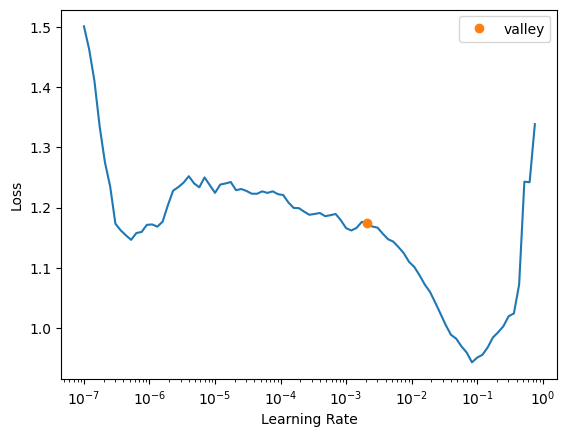

In [10]:
# Create a run using the squeezenet1_0 - model
# Each run will the saved to the project specified in the project path

run = neptune.init_run(project='tds-ws23/model-comparison', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ZjExOTA0Yy0zZjhhLTQ3Y2MtYjYzNy1kY2Q1OGMwODAyYWUifQ==",
                   tags="squeezenet1_0")

# Neptune callback object
neptune_cbk = NeptuneCallback(run=run)

# Callback for logging metrics after each epoch
class NeptuneRecorderCallback(Callback):
      def after_epoch(self):
        # Get the current epoch number
        epoch = self.learn.epoch

        # Convert the AvgMetric to a float and log the accuracy
        # Save the metrics in different paths, to make sure each epoch is saved
        accuracy = self.learn.recorder.metrics[-1].value
        run[f'epoch_{epoch}/accuracy'].log(accuracy)

        # Log the validation loss
        valid_loss = self.learn.recorder.log[-1]
        run[f'epoch_{epoch}/valid_loss'].log(valid_loss)


# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run
learner = vision_learner(dls, squeezenet1_0, cbs=[neptune_cbk], metrics=accuracy)

# Find learning rate
lr_rate = learner.lr_find()
lr = lr_rate.valley

# Define Early Stopping Callback-function
early_stop_cbk = EarlyStoppingCallback(monitor='valid_loss', patience=2)

# Train the model with optimal number of epochs
learner.fit_one_cycle(10, lr_max=lr, cbs=[early_stop_cbk, neptune_cbk, NeptuneRecorderCallback()])

run.stop()

 The EarlyStoppingCallback is set to monitor the validation loss during training. If the validation loss does not improve by at least 0.01 for 2 epochs, the training process will be stopped early. This helps in preventing overfitting and can also save time and computational power.

## Squeezenet1_1

<ipython-input-7-c038d00f2299>:2: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(project='tds-ws23/model-comparison', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ZjExOTA0Yy0zZjhhLTQ3Y2MtYjYzNy1kY2Q1OGMwODAyYWUifQ==",


https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-37


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 81.5MB/s]
/usr/local/lib/python3.10/dist-packages/neptune_fastai/impl/__init__.py:247: UserWarning: NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.
  warnings.warn("NeptuneCallback: SaveModelCallback is necessary for uploading model checkpoints.")


epoch,train_loss,valid_loss,accuracy,time
0,0.587414,0.303627,0.905679,00:57
1,0.260888,0.258362,0.924278,00:53
2,0.237707,0.254560,0.930588,00:52
3,0.215894,0.218713,0.932248,00:52
4,0.219326,0.217061,0.925938,00:55
5,0.191908,0.216016,0.931252,00:55
6,0.192895,0.225958,0.931584,00:53
7,0.181474,0.211713,0.924278,00:54
8,0.192198,0.208044,0.931252,00:56
9,0.179001,0.206881,0.929924,00:54


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 96 operations to synchronize with Neptune. Do not kill this process.
All 96 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-37/metadata


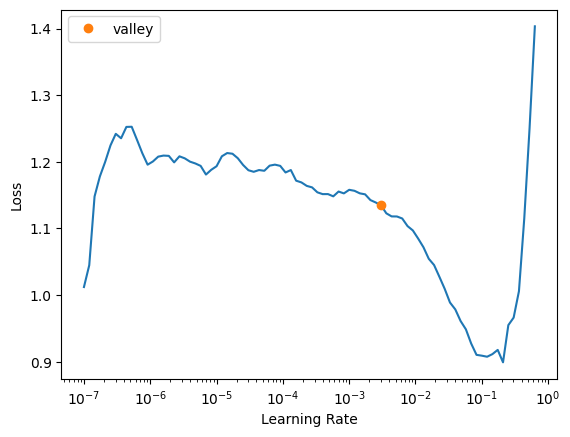

In [7]:
# Create a new run using a different model
run = neptune.init_run(project='tds-ws23/model-comparison', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ZjExOTA0Yy0zZjhhLTQ3Y2MtYjYzNy1kY2Q1OGMwODAyYWUifQ==",
                   tags="squeezenet1_1")

# Neptune callback object
neptune_cbk = NeptuneCallback(run=run)

# Callback for logging metrics after each epoch
class NeptuneRecorderCallback(Callback):
      def after_epoch(self):
        # Get the current epoch number
        epoch = self.learn.epoch

        # Convert the AvgMetric to a float and log the accuracy
        # Save the metrics in different paths, to make sure each epoch is saved
        accuracy = self.learn.recorder.metrics[-1].value
        run[f'epoch_{epoch}/accuracy'].log(accuracy)

        # Log the validation loss
        valid_loss = self.learn.recorder.log[-1]
        run[f'epoch_{epoch}/valid_loss'].log(valid_loss)

# Create a fast ai learner and pass the model and NeptuneCallback parameters including the specific run
learner = vision_learner(dls, squeezenet1_1, cbs=[neptune_cbk], metrics=accuracy)

# Find learning rate
lr_rate = learner.lr_find()
lr = lr_rate.valley

# Define Early Stopping Callback-function
early_stop_cbk = EarlyStoppingCallback(monitor='valid_loss', patience=2)

# Train the model with optimal number of epochs

learner.fit_one_cycle(10, lr_max=lr, cbs=[early_stop_cbk, neptune_cbk, NeptuneRecorderCallback()])


run.stop()

# Evaluation

The models were tracked in Neptune.ai and can be compared.
As you can see in the screenshot, the best performance was done by
  

*   squeezenet1_1
*   accuracy: 0.929924



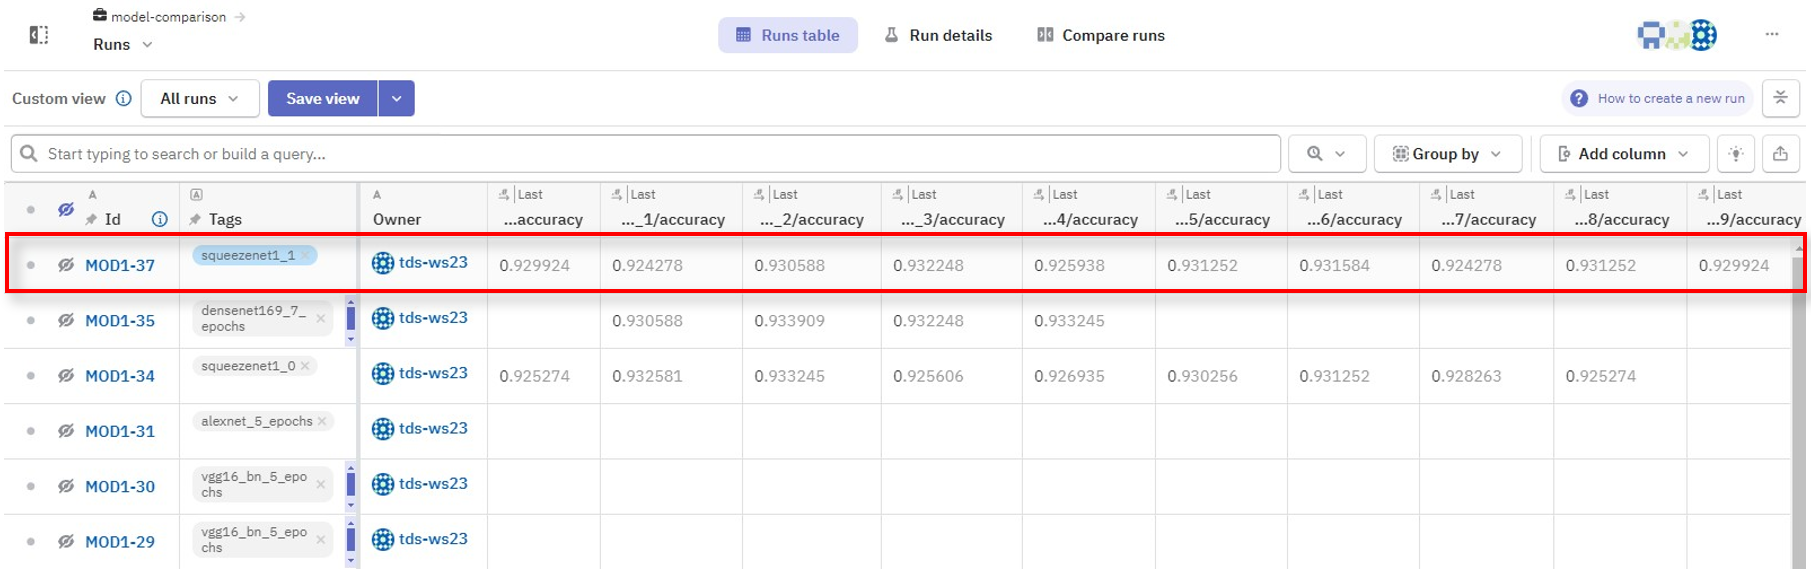

In [4]:
from IPython.display import Image
Image('/content/Screenshot-neptune.png')